In [22]:
import random

import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import MNIST

# Variational autoencoders


In [2]:
train_val_data = MNIST(
    "./data",
    download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]),
)
test_data = MNIST(
    "./data",
    download=True,
    train=False,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]),
)
val_size = 10000
train_size = len(train_val_data) - val_size
train_dataset, val_dataset = random_split(train_val_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

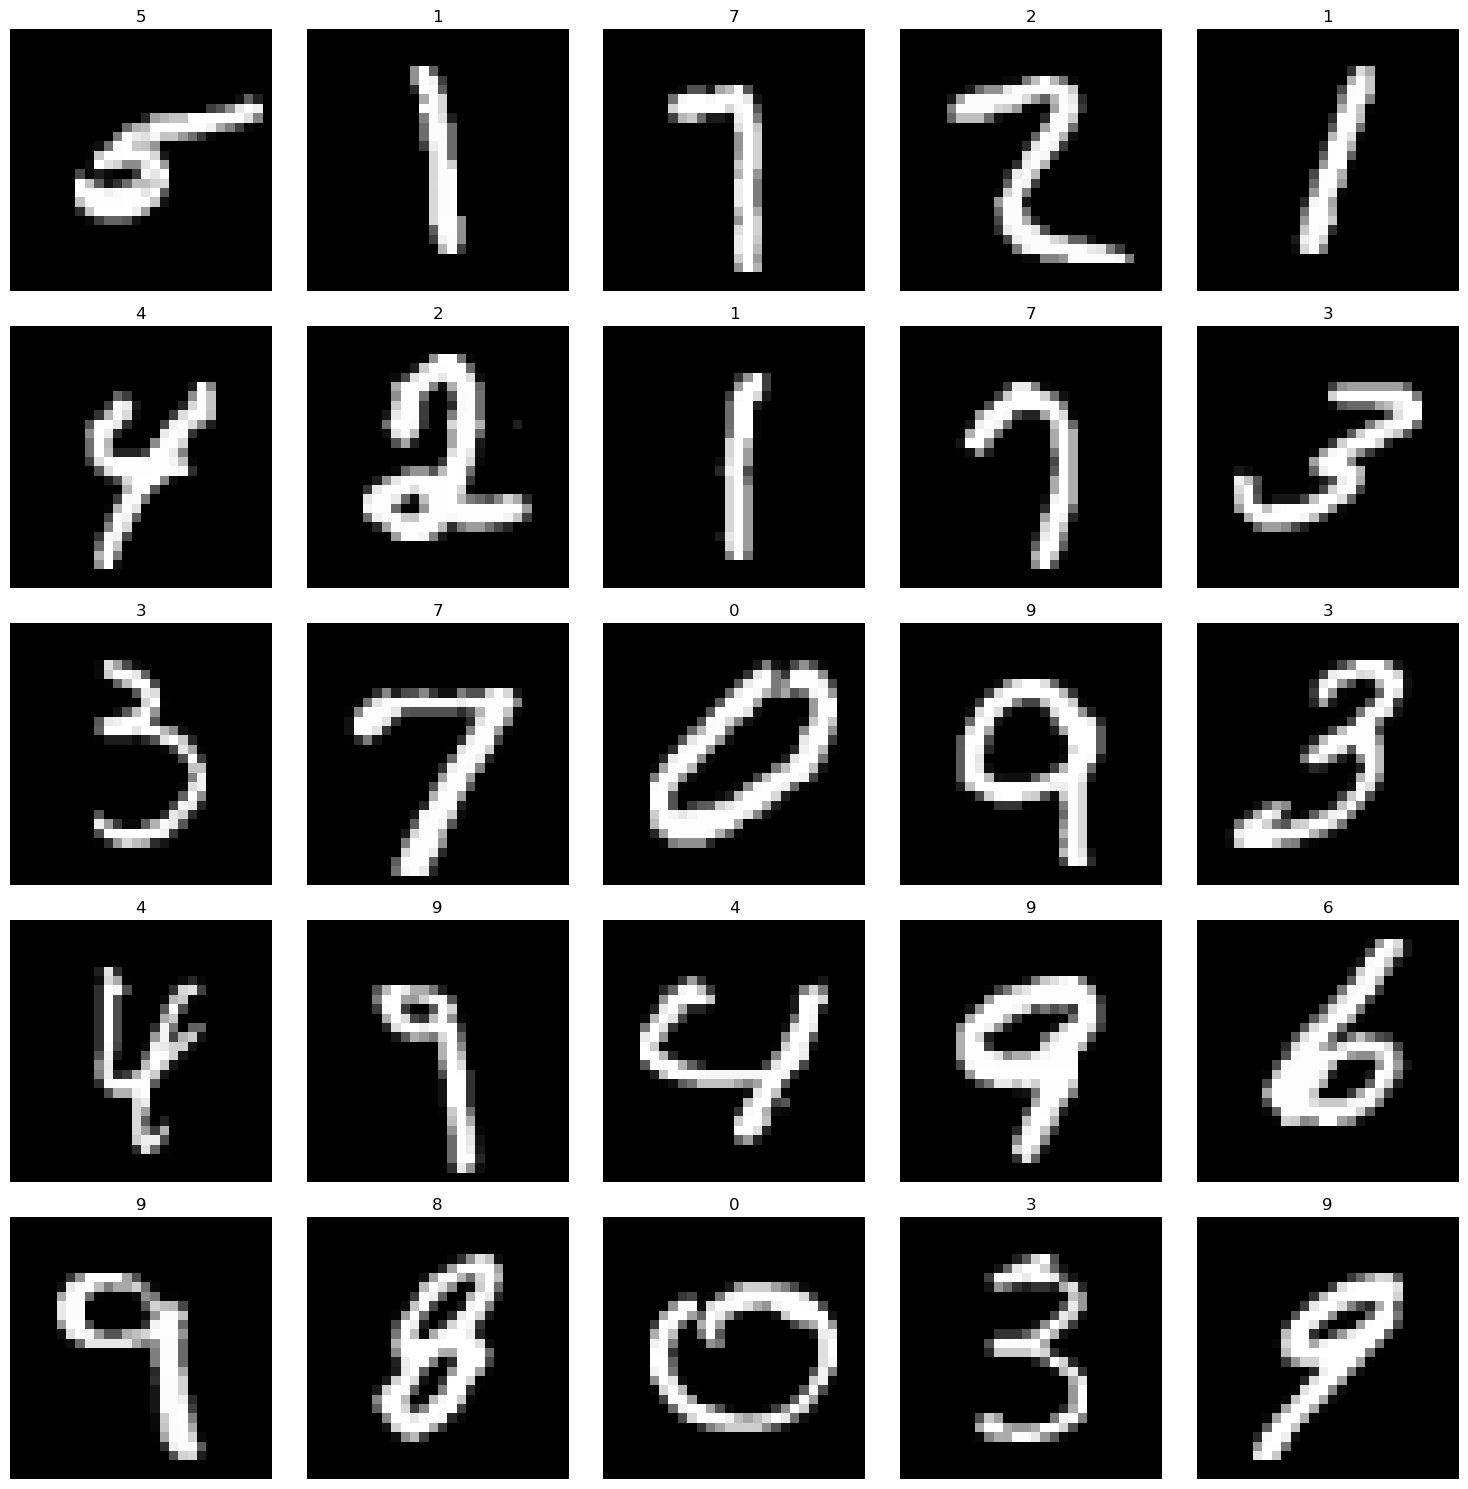

In [3]:
def display_random_image_grid(image_label_pairs):
    """
    Displays a grid of 25 randomly selected images with titles being their respective labels.
    If less than 25 images are provided, it displays all of them.

    :param image_label_pairs: A list of (image, label) tuples.
    """
    # Randomly sample 25 elements from the list (or all if the list is shorter).
    num_samples = min(25, len(image_label_pairs))
    sampled_image_label_pairs = random.sample(image_label_pairs, num_samples)

    # Set the dimensions of the grid.
    num_columns = 5
    num_rows = num_samples // num_columns + int(num_samples % num_columns > 0)

    # Create a figure with subplots in a grid.
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    for ax, (image, label) in zip(axes, sampled_image_label_pairs):
        ax.imshow(image.squeeze(0), cmap="gray")  # Display the image.
        ax.set_title(label)  # Set the title to be the label.
        ax.axis("off")  # Hide the axes ticks.

    # Hide any unused subplot areas.
    for ax in axes[num_samples:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


display_random_image_grid(list(train_dataset))

In [ ]:
class AE(L.LightningModule):
    def __init__(self, z_dim=10) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.z_dim = 10
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 10, 5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 2, 5),
            nn.AdaptiveAvgPool2d(4),  # will be (channels, 4,4) for sure
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2 * 4 * 4, z_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 64),
            nn.ReLU(),
            nn.Unflatten(1, (1, 8, 8)),
            nn.ConvTranspose2d(1, 5, 10),
            nn.ReLU(),
            nn.ConvTranspose2d(5, 1, 12),
        )

    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out, latent

    def training_step(self, batch, batch_idx):
        x, _label = batch
        out, latent = self(x)
        loss = F.mse_loss(x, out)
        self.log("Loss/train", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _label = batch
        out, latent = self(x)
        loss = F.mse_loss(x, out)
        self.log("Loss/val", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, _label = batch
        out, latent = self(x)
        loss = F.mse_loss(x, out)
        # self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


model = AE()
logger = TensorBoardLogger("tb_logs", name="autoencoder")
trainer = L.Trainer(max_epochs=20, log_every_n_steps=10)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [26]:
embs = []
labels = []
for d, label in test_data:
    _, latent = model(d.unsqueeze(0))
    embs.append(latent.detach().numpy().flatten())
    labels.append(label)
embs = np.array(embs)
labels = np.array(labels)

In [27]:
embs.shape, labels.shape

((10000, 10), (10000,))

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embs)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.004s...
[t-SNE] Computed neighbors for 10000 samples in 0.655s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.806730
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.027153
[t-SNE] KL divergence after 300 iterations: 2.795116


/var/folders/q6/dnbrfy_s2px965yzdl8jp8800000gp/T/ipykernel_46979/1100850731.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', num_classes)


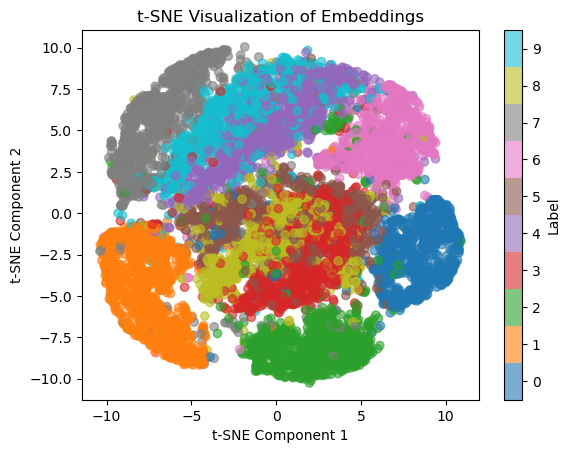

In [40]:
num_classes = len(np.unique(labels))
# Define a colormap with discrete colors
cmap = plt.cm.get_cmap("tab10", num_classes)

# Create the scatter plot
scatter = plt.scatter(
    tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=cmap, alpha=0.6
)

# Create a colorbar with discrete boundaries
bounds = np.arange(-0.5, len(np.unique(labels)) + 0.5, 1)  # boundaries for each label
norm = plt.Normalize(vmin=min(labels) - 0.5, vmax=max(labels) + 0.5)
cb = plt.colorbar(
    scatter,
    spacing="proportional",
    ticks=np.arange(min(labels), max(labels) + 1),
    boundaries=bounds,
    format="%1i",
    norm=norm,
)
cb.set_label("Label")

# Set plot title and labels
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()